# 1. Import Dependencies

In [32]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

# 2. Import df Amazon Sale Report

In [5]:
# Connection Parameter
host = 'localhost'
port = '5432'
dfbase = 'airflow'
user = 'airflow'
password = 'airflow'

connection = psycopg2.connect(
    host=host,
    port=port,
    dfbase=dfbase,
    user=user,
    password=password)
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dfbase}')

In [6]:
# Pull Amazon Sale Report df
result = engine.execute("SELECT * FROM amazon_sale_report")
rows = result.fetchall()
df = pd.dfFrame(rows, columns=result.keys())

# 3. df Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [8]:
df.set_index('index', inplace=True)

In [9]:
#Show Unique Values of dfset
print(df.nunique())

Order ID              120378
Date                      91
Status                    13
Fulfilment                 2
Sales Channel              2
ship-service-level         2
Style                   1377
SKU                     7195
Category                   9
Size                      11
ASIN                    7190
Courier Status             3
Qty                       10
currency                   1
Amount                  1410
ship-city               8955
ship-state                69
ship-postal-code        9459
ship-country               1
promotion-ids           5787
B2B                        2
fulfilled-by               1
Unnamed: 22                1
dtype: int64


Order ID               0.000000
Date                   0.000000
Status                 0.000000
Fulfilment             0.000000
Sales Channel          0.000000
ship-service-level     0.000000
Style                  0.000000
SKU                    0.000000
Category               0.000000
Size                   0.000000
ASIN                   0.000000
Courier Status         5.328164
Qty                    0.000000
currency               6.043807
Amount                 6.043807
ship-city              0.025586
ship-state             0.025586
ship-postal-code       0.025586
ship-country           0.025586
promotion-ids         38.110487
B2B                    0.000000
fulfilled-by          69.546811
Unnamed: 22           38.030626
dtype: float64


<Axes: >

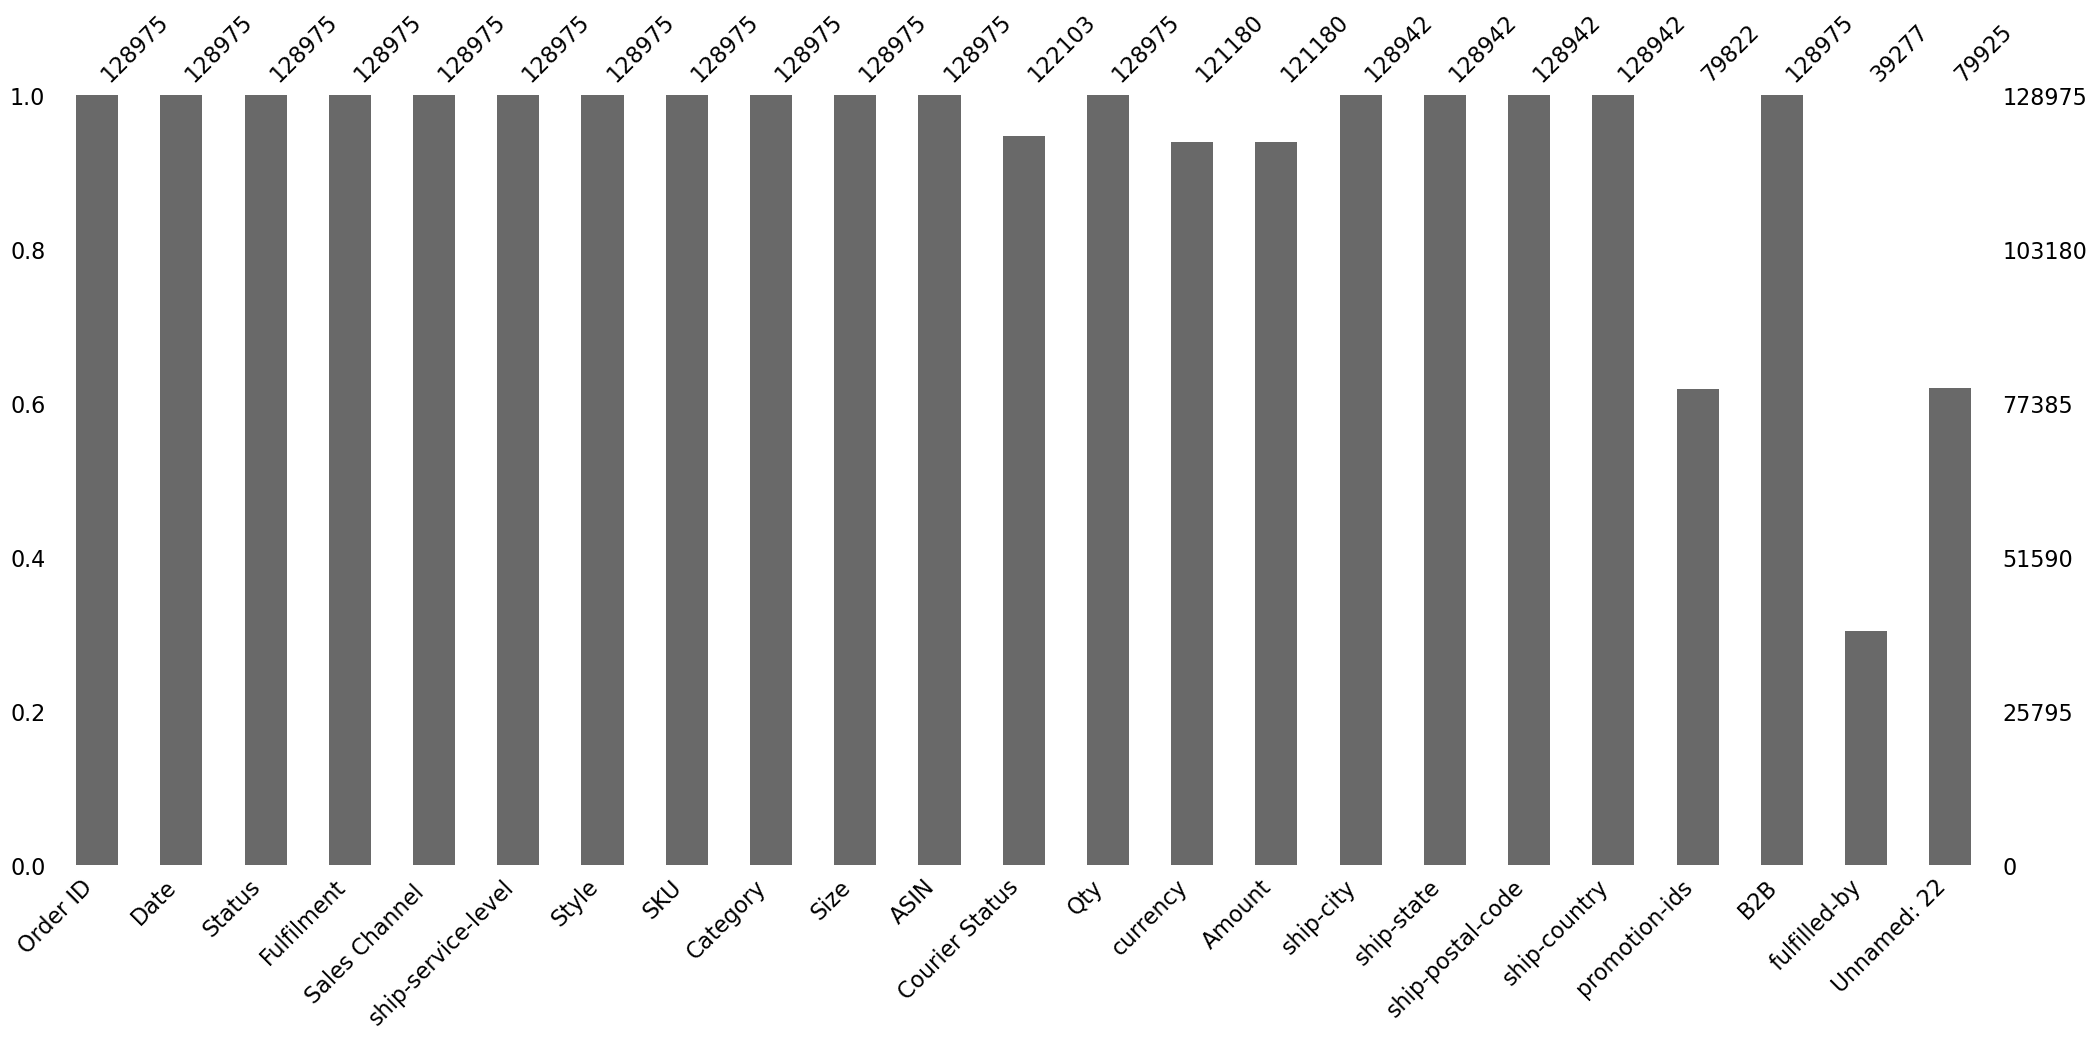

In [30]:
def nan_percentage(df):
    nan_percentage = (df.isna().sum()/len(df))*100
    return nan_percentage
print(nan_percentage(df))
msno.bar(df)

As you can see, column `promotion-ids`, `fulfilled-by`, and `Unnamed: 22` NaN df are quite high. `promotion-ids` NaN df about 38.1%, `fulfilled-by` about 69.5%, and `Unnamed: 22` about 38%. Suppose the maximum NaN value threshold for this project is:

* Above 30% null values: drop column
* Below 30% null values: drop rows or imputation

Not only that, column `currency`, `ship-country`, and `fulfilled-by` number of unique values are only 1. In conclusion, we have to drop these columns:
- `promotion-ids`
- `fulfilled-by`
- `Unnamed: 22`
- `currency`
- `ship-country`

*Note: Assumed we don't use those columns in the future, so we could instantly ignore those columns.

In [24]:
df_unique = df.drop_duplicates()
duplicate_df = len(df) - len(df_unique)
print(f"Number of dropped duplicated df: {duplicate_df}")

drop_column_list = ['promotion-ids', 
                   'fulfilled-by', 
                   'Unnamed: 22', 
                   'currency', 
                   'ship-country']
df_drop = df_unique.drop(drop_column_list, axis=1)
df_drop_na = df_drop.dropna(subset=['Courier Status', 
                                    'ship-city', 
                                    'ship-state', 
                                    'ship-postal-code'])

Number of dropped duplicated data: 6


In [156]:
def hist_boxplot(df, x, bins, title, x_label, y_label):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 0.5]}, sharex=True)
    sns.histplot(df[x], ax=ax[0], kde=True, kde_kws={'bw_adjust': 4}, bins=bins)
    ax[1].set_ylabel(y_label)
    sns.boxplot(x=df[x], ax=ax[1])
    
    mean = df[x].mean()
    median = df[x].median()
    mode = df[x].mode().values[0]
    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    if min(df[x])== 0:
        lower_limit = 0
    else:
        lower_limit = q1 - 1.5 * iqr

    stats_dict = {'mean': mean,
                  'median': median,
                  'mode': mode,
                  'q1': q1,
                  'q3': q3,
                  'upper limit': upper_limit,
                  'lower limit': lower_limit
                 }
    stats = pd.DataFrame(stats_dict, index=[0])

    for i in range(2):
        ax[i].axvline(mean, color='red', linestyle='--', label=f'Mean: {round(mean, 1)}', alpha=0.5)
        ax[i].axvline(median, color='green', linestyle='--', label=f'Median: {round(median, 1)}', alpha=0.5)
        ax[i].axvline(mode, color='blue', linestyle='--', label=f'Mode: {mode}', alpha=0.5)
        ax[i].axvline(upper_limit, color='orange', linestyle='--', label=f'Upper Limit: {round(upper_limit, 1)}', alpha=0.5)
        ax[i].axvline(lower_limit, color='purple', linestyle='--', label=f'Lower Limit: {round(lower_limit, 1)}', alpha=0.5)
    
    ax[0].legend()
    plt.suptitle(title)
    plt.xlabel(x_label)
    plt.tight_layout()
    plt.show()

    df_no_outlier = df[df[x]<=upper_limit]
    df_outlier = df[df[x]>upper_limit]

    return df_no_outlier, df_outlier, stats

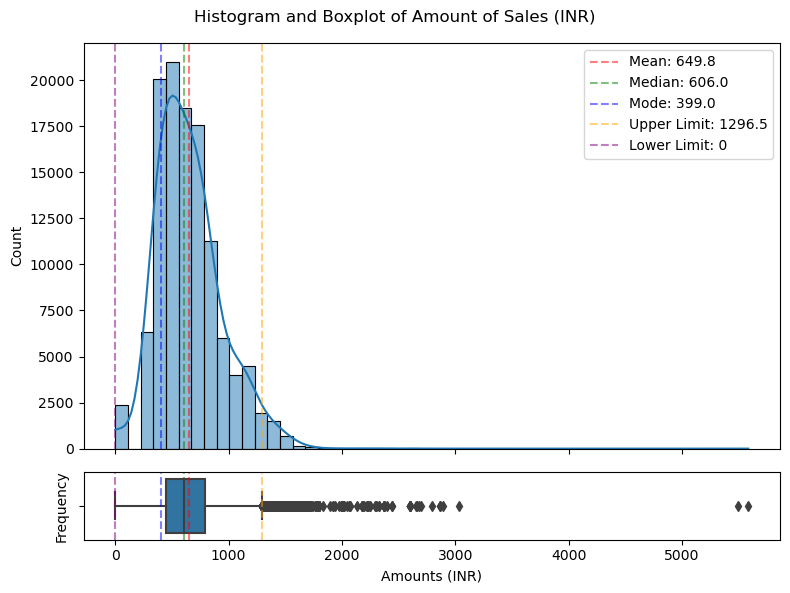

,mean,median,mode,q1,q3,upper limit,lower limit
0,649.774939,606.0,399.0,449.0,788.0,1296.5,0


In [157]:
df_no_outlier, df_outlier, stats = hist_boxplot(df_drop_na, 
                                         'Amount', 
                                         50, 
                                         'Histogram and Boxplot of Amount of Sales (INR)', 
                                         'Amounts (INR)', 
                                         'Frequency')
display(stats)

In [153]:
df_outlier.head()

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,B2B
index,,,,,,,,,,,,,,,,,,
102,408-7698765-2294756,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,SET277,SET277-KR-NP-XXL,Set,XXL,B0983FZLXC,Shipped,1,1338.0,AMBARNATH,MAHARASHTRA,421502.0,False
146,171-0131752-2560336,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,SET355,SET355-KR-PP-M,Set,M,B09RKDPHFP,Shipped,1,1399.0,BARABANKI,UTTAR PRADESH,225001.0,False
243,408-2759943-9849959,04-30-22,Shipped,Amazon,Amazon.in,Expedited,SET363,SET363-KR-NP-XXL,Set,XXL,B09TH61GMF,Shipped,1,1338.0,KOLKATA,WEST BENGAL,700051.0,False
265,171-6655820-6440356,04-30-22,Shipped,Amazon,Amazon.in,Expedited,J0008,J0008-SKD-XXL,Set,XXL,B0894WT71H,Shipped,2,2130.0,MUMBAI,MAHARASHTRA,400101.0,False
299,404-7491342-1035558,04-30-22,Shipped,Amazon,Amazon.in,Expedited,J0280,J0280-SKD-S,Set,S,B08QGM7FCC,Shipped,1,1463.0,THANE,MAHARASHTRA,401107.0,False


In [18]:
# Columns name standardization
columns_list = df_drop.columns
modified_columns_list = []
for i in columns_list:
    modified_column = i.lower().replace(" ", "_").replace("-", "_")
    modified_columns_list.append(modified_column)

df_drop.columns = modified_columns_list

In [19]:
df_drop

,order_id,date,status,fulfilment,sales_channel_,ship_service_level,style,sku,category,size,asin,courier_status,qty,amount,ship_city,ship_state,ship_postal_code,b2b
index,,,,,,,,,,,,,,,,,,
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,None,0,647.62,MUMBAI,MAHARASHTRA,400081.0,False
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.00,BENGALURU,KARNATAKA,560085.0,False
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,True
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,None,0,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,False
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.00,CHENNAI,TAMIL NADU,600073.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,406-6001380-7673107,05-31-22,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,XL,B098112V2V,Shipped,1,517.00,HYDERABAD,TELANGANA,500013.0,False
128971,402-9551604-7544318,05-31-22,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,M,B09VC6KHX8,Shipped,1,999.00,GURUGRAM,HARYANA,122004.0,False
128972,407-9547469-3152358,05-31-22,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,XXL,B0982YZ51B,Shipped,1,690.00,HYDERABAD,TELANGANA,500049.0,False
